In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import warnings
warnings.filterwarnings('ignore')

class FullyCorrectedSupplyChainGA:
    def __init__(self, parameters):
       
        self.params = parameters
        self.population_size = 50
        self.generations = 100
        self.mutation_rate = 0.15
        self.crossover_rate = 0.8

    def get_x_bar(self):
     
        return (self.params['v'] + self.params['u']) / 2

    def demand_function(self, p):
        return self.params['a'] - self.params['b'] * (p - self.params['pr'])

    def f_x(self, x):
        
        u, v = self.params['u'], self.params['v']
        return 1.0 / (v - u) if u <= x <= v else 0.0

    def calculate_primary_supplier_profit(self, genes):
       
        Qp, Qb, Ql, p, wl, wp, wb, eta = genes
        P1 = self.params['P1']
        c1 = self.params['c1']
        beta1 = self.params['beta1']
        wsp = self.params['wsp']
        x_bar = self.get_x_bar()
        lambda_ps = self.params['lambda_ps']

        profit = ((1 - P1) * wp * x_bar * Qp + 
                  P1 * wsp * x_bar * Qp - 
                  c1 * Qp + 
                  P1 * beta1 * (wp - wsp) * x_bar * Qp - 
                  wp * lambda_ps * (1 + P1) * Qp)
        return max(profit, -1e6)

    def calculate_backup_supplier_profit(self, genes):
       
        Qp, Qb, Ql, p, wl, wp, wb, eta = genes
        P1, P2 = self.params['P1'], self.params['P2']
        c2 = self.params['c2']
        beta2 = self.params['beta2']
        wsb = self.params['wsb']
        lambda_bs = self.params['lambda_bs']
        r = self.params['r']
        x_bar = self.get_x_bar()
        D_p = self.demand_function(p)
        u, v = self.params['u'], self.params['v']  

       
        rev1 = P1 * ((1 - P2) * wb + P2 * wsb) * min(D_p, Qb)
        demand_remaining = max(0, D_p - x_bar * Qp)
        rev2 = (1 - P1) * ((1 - P2) * wb + P2 * wsb) * min(demand_remaining, Qb)

        
        cost1 = c2 * P1 * min(D_p, Qb)
        cost2 = c2 * (1 - P1) * min(demand_remaining, Qb)

        
        risk_cost = lambda_bs * wb * (1 + P2) * Qb
        return_benefit = (1 - P2) * r * Qb
        
        
        disruption = self.calculate_backup_disruption_integral(Qp, Qb, D_p, P1, P2, beta2, wb, wsb, u, v)

        profit = rev1 + rev2 - cost1 - cost2 - risk_cost + return_benefit + disruption
        return max(profit, -1e6)
    
    def calculate_backup_disruption_integral(self, Qp, Qb, D_p, P1, P2, beta2, wb, wsb, u, v):
      
        if Qp <= 0:
            return 0
        
        def integrand(x):
            term1 = (1 - P1) * min(max(0, D_p - x * Qp), Qb)
            term2 = P1 * min(D_p, Qb)
            return P2 * beta2 * (wb - wsb) * (term1 + term2) * self.f_x(x)
        
        try:
            result, _ = quad(integrand, u, v)
            return result
        except:
            return 0

    def calculate_local_supplier_profit(self, genes):
        
        Qp, Qb, Ql, p, wl, wp, wb, eta = genes
        return max((wl - self.params['c3']) * Ql, -1e6)

    def calculate_retailer_profit(self, genes):
        
        Qp, Qb, Ql, p, wl, wp, wb, eta = genes
        D_p = self.demand_function(p)

        
        if Qp >= D_p or D_p <= 0:
            return -1e6
        if not (D_p >= Qb and D_p >= Ql):
            return -1e6
        if not (self.params['c1'] < wp < wb < wl and self.params['c2'] < wb < p):
            return -1e6
        if not (0 < eta < 1):
            return -1e6
        if any(gene <= 0 for gene in genes):
            return -1e6

        
        P1, P2 = self.params['P1'], self.params['P2']
        cs, cd, cl, cu = self.params['cs'], self.params['cd'], self.params['cl'], self.params['cu']
        c3, r = self.params['c3'], self.params['r']
        lambda_ = self.params.get('lambda_', 0.05)
        pr = self.params['pr']
        u, v = self.params['u'], self.params['v']
        x_bar = self.get_x_bar()

        profit = 0

        # ===== SCENARIO 1: P1·P2 (Both disrupted) =====
        term1 = (p * min(Ql, D_p) - 
                 cs * max(0, D_p - Ql) - 
                 cd * max(0, Ql - D_p) - 
                 (wl + cl) * Ql)
        profit += P1 * P2 * term1

        # ===== SCENARIO 2: P1·(1-P2) (Primary disrupted, backup works) =====
        term2 = ((p - wb - cu) * Qb + 
                 p * min(Ql, max(0, D_p - Qb)) - 
                 (wl + cl) * Ql - 
                 cs * max(0, D_p - Qb - Ql) - 
                 cd * max(0, Ql + Qb - D_p) - 
                 r * Qb)
        profit += P1 * (1 - P2) * term2

        # ===== SCENARIO 3: (1-P1)·P2 (Primary works, backup disrupted) =====
        base_term3 = (p - wp - cu) * min(x_bar * Qp, D_p)
        insurance_integral = self.calculate_insurance_integral_s3(Qp, Ql, D_p, eta, p, wl, cl, c3, u, v)
        int1 = self.calculate_integral_1(Qp, Ql, D_p, u, v)
        int2 = self.calculate_integral_2(Qp, Ql, D_p, u, v)
        int3 = self.calculate_integral_3(Qp, Ql, D_p, u, v)
        term3 = base_term3 + insurance_integral - cd * int1 - cs * int2 - cd * int3
        profit += (1 - P1) * P2 * term3

        # ===== SCENARIO 4: (1-P1)·(1-P2) (Both work) =====
        base_term4 = ((p - wp - cu) * min(x_bar * Qp, D_p) + 
                      (p - wb - cu) * min(Qb, max(0, D_p - x_bar * Qp)))
        insurance_integral_s4 = self.calculate_insurance_integral_s4(Qp, Qb, Ql, D_p, eta, p, wl, cl, c3, u, v)
        int1_s4 = self.calculate_integral_1(Qp, Ql, D_p, u, v)
        int4 = self.calculate_integral_4(Qp, Ql, Qb, D_p, u, v)
        int5 = self.calculate_integral_5(Qp, Ql, Qb, D_p, u, v)
        term4 = base_term4 + insurance_integral_s4 - cd * int1_s4 - r * Qb - cs * int4 - cd * int5
        profit += (1 - P1) * (1 - P2) * term4

        # Insurance cost
        profit -= lambda_ * pr * Qp * (1 + eta) ** 2

        return profit

    def calculate_insurance_integral_s3(self, Qp, Ql, D_p, eta, p, wl, cl, c3, u, v):
        """Insurance/penalty integrals for Scenario 3"""
        if Qp <= 0:
            return 0
        
        result = 0
        
        if eta > u:
            def integrand_bonus(x):
                remaining_demand = max(0, D_p - x * Qp)
                local_revenue = p * min(Ql, remaining_demand) - (wl + cl) * Ql
                return (eta - x) * local_revenue * self.f_x(x)
            
            try:
                lower = max(u, 0)
                upper = min(eta, v)
                if upper > lower:
                    bonus, _ = quad(integrand_bonus, lower, upper)
                    result += bonus
            except:
                pass
        
        if eta < v:
            def integrand_penalty(x):
                remaining_demand = max(0, D_p - x * Qp)
                local_revenue = p * min(Ql, remaining_demand) - (c3 + cl) * Ql
                return (x - eta) * local_revenue * self.f_x(x)
            
            try:
                lower = max(eta, u)
                upper = min(v, 1e6)
                if upper > lower:
                    penalty, _ = quad(integrand_penalty, lower, upper)
                    result += penalty
            except:
                pass
        
        return result

    def calculate_insurance_integral_s4(self, Qp, Qb, Ql, D_p, eta, p, wl, cl, c3, u, v):
        """Insurance/penalty integrals for Scenario 4"""
        if Qp <= 0:
            return 0
        
        result = 0
        
        if eta > u:
            def integrand_bonus(x):
                remaining_after_primary = max(0, D_p - x * Qp)
                remaining_after_backup = max(0, remaining_after_primary - Qb)
                local_revenue = p * min(Ql, remaining_after_backup) - (wl + cl) * Ql
                return (eta - x) * local_revenue * self.f_x(x)
            
            try:
                lower = max(u, 0)
                upper = min(eta, v)
                if upper > lower:
                    bonus, _ = quad(integrand_bonus, lower, upper)
                    result += bonus
            except:
                pass
        
        if eta < v:
            def integrand_penalty(x):
                remaining_after_primary = max(0, D_p - x * Qp)
                remaining_after_backup = max(0, remaining_after_primary - Qb)
                local_revenue = p * min(Ql, remaining_after_backup) - (c3 + cl) * Ql
                return (x - eta) * local_revenue * self.f_x(x)
            
            try:
                lower = max(eta, u)
                upper = min(v, 1e6)
                if upper > lower:
                    penalty, _ = quad(integrand_penalty, lower, upper)
                    result += penalty
            except:
                pass
        
        return result

    def calculate_integral_1(self, Qp, Ql, D_p, u, v):
        """∫[D(p)/Qp to v] (xQp - D(p))·f(x)dx"""
        if Qp <= 0:
            return 0
        lower = max(D_p / Qp, u)
        upper = v
        if lower >= upper:
            return 0
        try:
            integrand = lambda x: (x * Qp - D_p) * self.f_x(x)
            result, _ = quad(integrand, lower, upper)
            return max(0, result)
        except:
            return 0

    def calculate_integral_2(self, Qp, Ql, D_p, u, v):
        """∫[u to (D(p)-Ql)/Qp] (D(p) - xQp - Ql)·f(x)dx"""
        if Qp <= 0:
            return 0
        lower = u
        upper = min((D_p - Ql) / Qp, v)
        if lower >= upper:
            return 0
        try:
            integrand = lambda x: (D_p - x * Qp - Ql) * self.f_x(x)
            result, _ = quad(integrand, lower, upper)
            return max(0, result)
        except:
            return 0

    def calculate_integral_3(self, Qp, Ql, D_p, u, v):
        """∫[(D(p)-Ql)/Qp to D(p)/Qp] (xQp + Ql - D(p))·f(x)dx"""
        if Qp <= 0:
            return 0
        lower = max((D_p - Ql) / Qp, u)
        upper = min(D_p / Qp, v)
        if lower >= upper:
            return 0
        try:
            integrand = lambda x: (x * Qp + Ql - D_p) * self.f_x(x)
            result, _ = quad(integrand, lower, upper)
            return max(0, result)
        except:
            return 0

    def calculate_integral_4(self, Qp, Ql, Qb, D_p, u, v):
        """∫[u to (D(p)-Qb-Ql)/Qp] (D(p) - xQp - Qb - Ql)·f(x)dx"""
        if Qp <= 0:
            return 0
        lower = u
        upper = min((D_p - Qb - Ql) / Qp, v)
        if lower >= upper:
            return 0
        try:
            integrand = lambda x: (D_p - x * Qp - Qb - Ql) * self.f_x(x)
            result, _ = quad(integrand, lower, upper)
            return max(0, result)
        except:
            return 0

    def calculate_integral_5(self, Qp, Ql, Qb, D_p, u, v):
        """∫[(D(p)-Qb-Ql)/Qp to (D(p)-Ql)/Qp] (xQp + Qb + Ql - D(p))·f(x)dx"""
        if Qp <= 0:
            return 0
        lower = max((D_p - Qb - Ql) / Qp, u)
        upper = min((D_p - Ql) / Qp, v)
        if lower >= upper:
            return 0
        try:
            integrand = lambda x: (x * Qp + Qb + Ql - D_p) * self.f_x(x)
            result, _ = quad(integrand, lower, upper)
            return max(0, result)
        except:
            return 0

    def calculate_total_supply_chain_profit(self, genes):
        return (self.calculate_retailer_profit(genes) +
                self.calculate_primary_supplier_profit(genes) +
                self.calculate_backup_supplier_profit(genes) +
                self.calculate_local_supplier_profit(genes))

    def create_individual(self):
        p = np.random.uniform(self.params['pr']*1.1, self.params['pr']*2.5)
        D_p = self.demand_function(p)
        Qp = np.random.uniform(5, min(D_p*0.8, 100))
        Qb = np.random.uniform(5, min(D_p*0.9, 80))
        Ql = np.random.uniform(5, min(D_p*0.9, 80))
        wp = np.random.uniform(self.params['c1']+1, p-15)
        wb = np.random.uniform(max(wp+1, self.params['c2']+1), p-10)
        wl = np.random.uniform(wb+1, p-5)
        eta = np.random.uniform(0.1, 0.9)
        return np.array([Qp, Qb, Ql, p, wl, wp, wb, eta])

    def repair_individual(self, ind):
        ind = np.abs(ind)
        Qp, Qb, Ql, p, wl, wp, wb, eta = ind
        p = max(self.params['pr']*1.05, p)
        wp = np.clip(wp, self.params['c1']+0.1, p-10)
        wb = np.clip(wb, max(wp+0.1, self.params['c2']+0.1), p-5)
        wl = np.clip(wl, wb+0.1, p-1)
        D_p = self.demand_function(p)
        if D_p <= 0:
            p = self.params['pr']*1.5
            D_p = self.demand_function(p)
        Qp = min(Qp, D_p*0.85)
        Qb = min(Qb, D_p)
        Ql = min(Ql, D_p)
        eta = np.clip(eta, 0.01, 0.99)
        return np.array([Qp, Qb, Ql, p, wl, wp, wb, eta])

    def tournament_selection(self, pop, fitness, t_size=3):
        selected = []
        for _ in range(len(pop)):
            idx = np.random.choice(len(pop), t_size, replace=False)
            winner_idx = idx[np.argmax(fitness[idx])]
            selected.append(pop[winner_idx].copy())
        return np.array(selected)

    def crossover(self, p1, p2):
        if np.random.random() < self.crossover_rate:
            mask = np.random.random(len(p1)) < 0.5
            c1 = np.where(mask, p1, p2)
            c2 = np.where(mask, p2, p1)
            return c1, c2
        return p1.copy(), p2.copy()

    def mutate(self, ind):
        if np.random.random() < self.mutation_rate:
            ind = ind.copy()
            mutation_mask = np.random.random(len(ind)) < 0.3
            for i in range(len(ind)):
                if mutation_mask[i]:
                    if i == 7:
                        ind[i] += np.random.normal(0, 0.1)
                    elif i == 3:
                        ind[i] += np.random.normal(0, np.abs(ind[i]) * 0.05)
                    else:
                        ind[i] += np.random.normal(0, np.abs(ind[i]) * 0.1)
        return self.repair_individual(ind)

    def optimize(self):
        print(" Genetic Algorithm - All formulas verified!")
        print(f"Using x̄ = {self.get_x_bar():.3f}")

        population = np.array([self.create_individual() for _ in range(self.population_size)])
        best_fitness_history = []
        best_individual = None
        best_fitness = -np.inf

        for gen in range(self.generations):
            fitness = np.array([self.calculate_retailer_profit(ind) for ind in population])
            idx_best = np.argmax(fitness)
            if fitness[idx_best] > best_fitness:
                best_fitness = fitness[idx_best]
                best_individual = population[idx_best].copy()
            best_fitness_history.append(best_fitness)

            if gen % 20 == 0:
                print(f"Gen {gen}: Best = {best_fitness:.2f}")

            if gen < self.generations - 1:
                selected = self.tournament_selection(population, fitness)
                new_pop = []
                elite_count = max(1, self.population_size // 10)
                elite_idx = np.argsort(fitness)[-elite_count:]
                for idx in elite_idx:
                    new_pop.append(population[idx])
                while len(new_pop) < self.population_size:
                    p1, p2 = selected[np.random.choice(len(selected), 2, replace=False)]
                    c1, c2 = self.crossover(p1, p2)
                    c1 = self.mutate(c1)
                    c2 = self.mutate(c2)
                    new_pop.extend([c1, c2])
                population = np.array(new_pop[:self.population_size])

        if best_individual is not None:
            profit_breakdown = {
                'retailer': best_fitness,
                'primary': self.calculate_primary_supplier_profit(best_individual),
                'backup': self.calculate_backup_supplier_profit(best_individual),
                'local': self.calculate_local_supplier_profit(best_individual),
                'total_chain': self.calculate_total_supply_chain_profit(best_individual)
            }
        else:
            profit_breakdown = {'retailer': -np.inf, 'primary': -np.inf, 
                               'backup': -np.inf, 'local': -np.inf, 'total_chain': -np.inf}

        return {
            'best_solution': best_individual,
            'best_profit': best_fitness,
            'fitness_history': best_fitness_history,
            'method': 'Fully Corrected GA',
            'profit_breakdown': profit_breakdown
        }

    def print_solution(self, result):
        if result['best_solution'] is None:
            print(" No feasible solution found!")
            return

        sol = result['best_solution']
        profit = result['best_profit']
        breakdown = result.get('profit_breakdown', {})

        print(f"\n{'-'*60}\n SOLUTION\n{'-'*60}")
        print(f"Retailer Profit: ${profit:,.0f}")
        print(f"\nVariables: Qp={sol[0]:.1f}, Qb={sol[1]:.1f}, Ql={sol[2]:.1f}")
        print(f"           p={sol[3]:.1f}, wl={sol[4]:.1f}, wp={sol[5]:.1f}, wb={sol[6]:.1f}, η={sol[7]:.3f}")
        print(f"\nPROFITS:")
        print(f"  Retailer:   ${breakdown.get('retailer', 0):,.0f}")
        print(f"  Primary:    ${breakdown.get('primary', 0):,.0f}")
        print(f"  Backup:     ${breakdown.get('backup', 0):,.0f}")
        print(f"  Local:      ${breakdown.get('local', 0):,.0f}")
        print(f"  Total:      ${breakdown.get('total_chain', 0):,.0f}")


# Run optimization
def run_fully_corrected_optimization():
    parameters = {
        'a': 500, 'b': 20, 'pr': 100,
        'u': 0.4, 'v': 0.9,
        'P1': 0.25, 'P2': 0.1,
        'wsp': 3, 'beta1': 0.6, 'c1': 4, 'lambda_ps': 0.05,
        'wsb': 8, 'c2': 7, 'beta2': 0.6, 'lambda_bs': 0.05,
        'r': 1, 'wl0': 40, 'c3': 20, 'cs': 10, 'cd': 5,
        'cl': 40, 'cu': 3, 'lambda_': 0.05, 'eta0': 0.6
    }

    ga = FullyCorrectedSupplyChainGA(parameters)
    result = ga.optimize()
    ga.print_solution(result)
    return result, ga

if __name__ == "__main__":
    result, optimizer = run_fully_corrected_optimization()

 Genetic Algorithm - All formulas verified!
Using x̄ = 0.650
Gen 0: Best = 906.32
Gen 20: Best = 7222.78
Gen 40: Best = 11476.87
Gen 60: Best = 17136.13
Gen 80: Best = 25538.40

------------------------------------------------------------
 SOLUTION
------------------------------------------------------------
Retailer Profit: $30,531

Variables: Qp=222.4, Qb=356.9, Ql=41.6
           p=105.0, wl=51.8, wp=7.6, wb=9.6, η=0.031

PROFITS:
  Retailer:   $30,531
  Primary:    $41
  Backup:     $839
  Local:      $1,323
  Total:      $32,734


Trying to optimize it


----------------------------------------------------------------------
 SUPPLY CHAIN OPTIMIZATION WITH GENETIC ALGORITHM

----------------------------------------------------------------------
OPTION 1: Single Optimization Run
 Enhanced GA with Performance Improvements
Population: 100, Generations: 200
Using x̄ = 0.650

Gen 0: Best = 6385.79 (↑inf)
Gen 20: Best = 14406.61 (↑829.54)
Gen 30: Best = 22554.46 (↑178.38)
Gen 50: Best = 24548.77 (↑44.34)
Gen 60: Best = 24799.43 (↑11.19)
Gen 100: Best = 25435.70 (↑9.53)
Gen 120: Best = 25688.41 (↑18.11)
Gen 130: Best = 25737.99 (↑0.28)
Gen 140: Best = 25740.58 (↑0.04)
Gen 150: Best = 25740.81 (↑0.00)
Gen 160: Best = 25740.83 (↑0.00)

OPTIMIZED SOLUTION
 Retailer Profit: $25,740.83

Decision Variables:
   Quantities: Qp=23.08, Qb=285.00, Ql=15.01
   Price: p=$110.00
   Wholesale: wp=$4.80, wb=$8.40, wl=$9.40
   Insurance: η=0.529

PROFIT BREAKDOWN:
   Retailer:   $   25,740.83
   Primary:    $      -29.93
   Backup:     $      519.24
   Local:

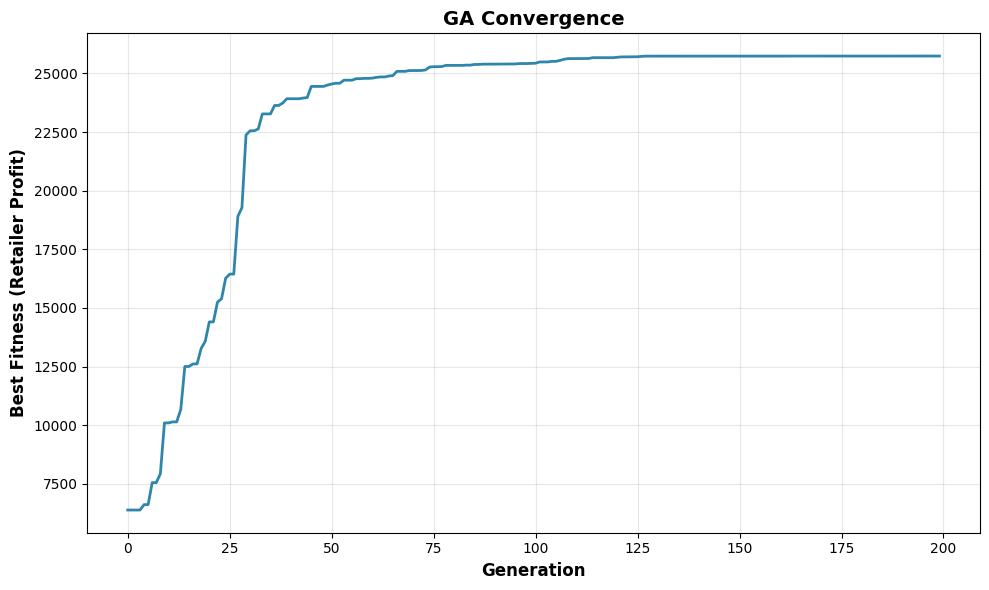

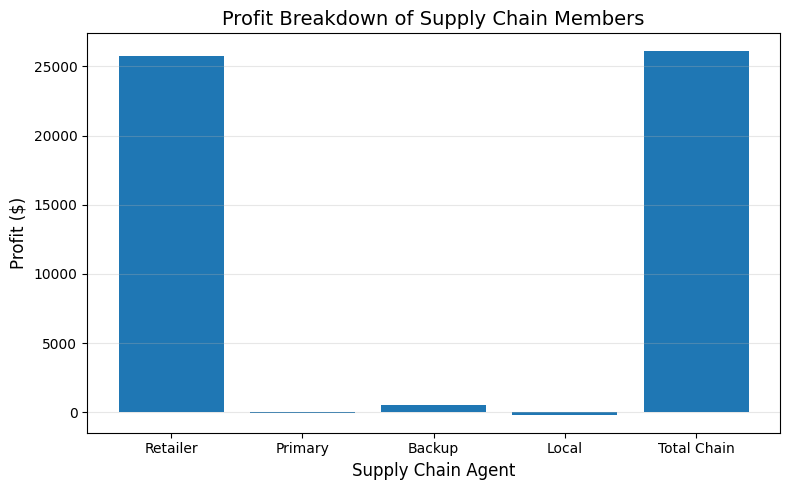

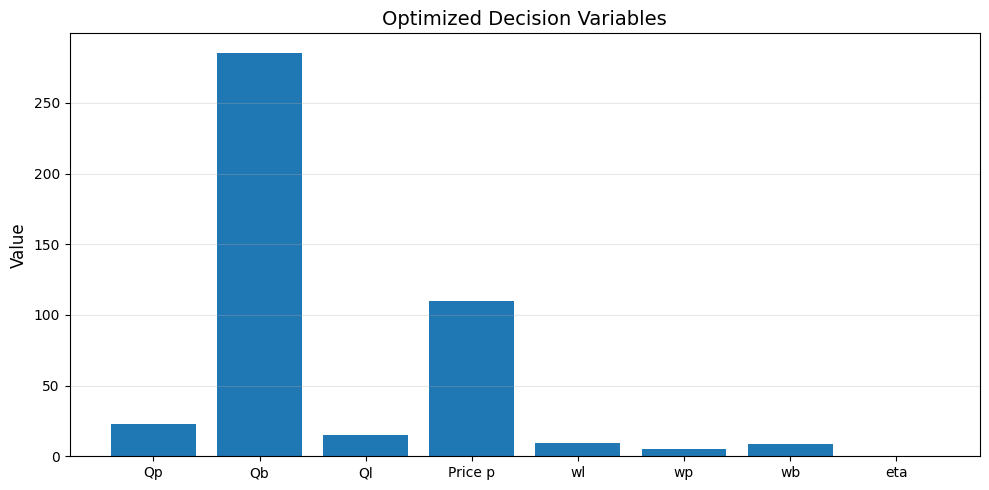



----------------------------------------------------------------------
OPTION 2: Multiple Trials for Validation
----------------------------------------------------------------------

 RUNNING 5 INDEPENDENT GA TRIALS FOR VALIDATION


──────────────────────────────────────────────────────────────────────
Trial 1/5
──────────────────────────────────────────────────────────────────────
✓ Retailer Profit: $25,739.70
✓ Total Chain: $26,069.84

──────────────────────────────────────────────────────────────────────
Trial 2/5
──────────────────────────────────────────────────────────────────────
✓ Retailer Profit: $25,740.73
✓ Total Chain: $26,070.95

──────────────────────────────────────────────────────────────────────
Trial 3/5
──────────────────────────────────────────────────────────────────────
✓ Retailer Profit: $25,739.91
✓ Total Chain: $26,069.46

──────────────────────────────────────────────────────────────────────
Trial 4/5
────────────────────────────────────────────────────────

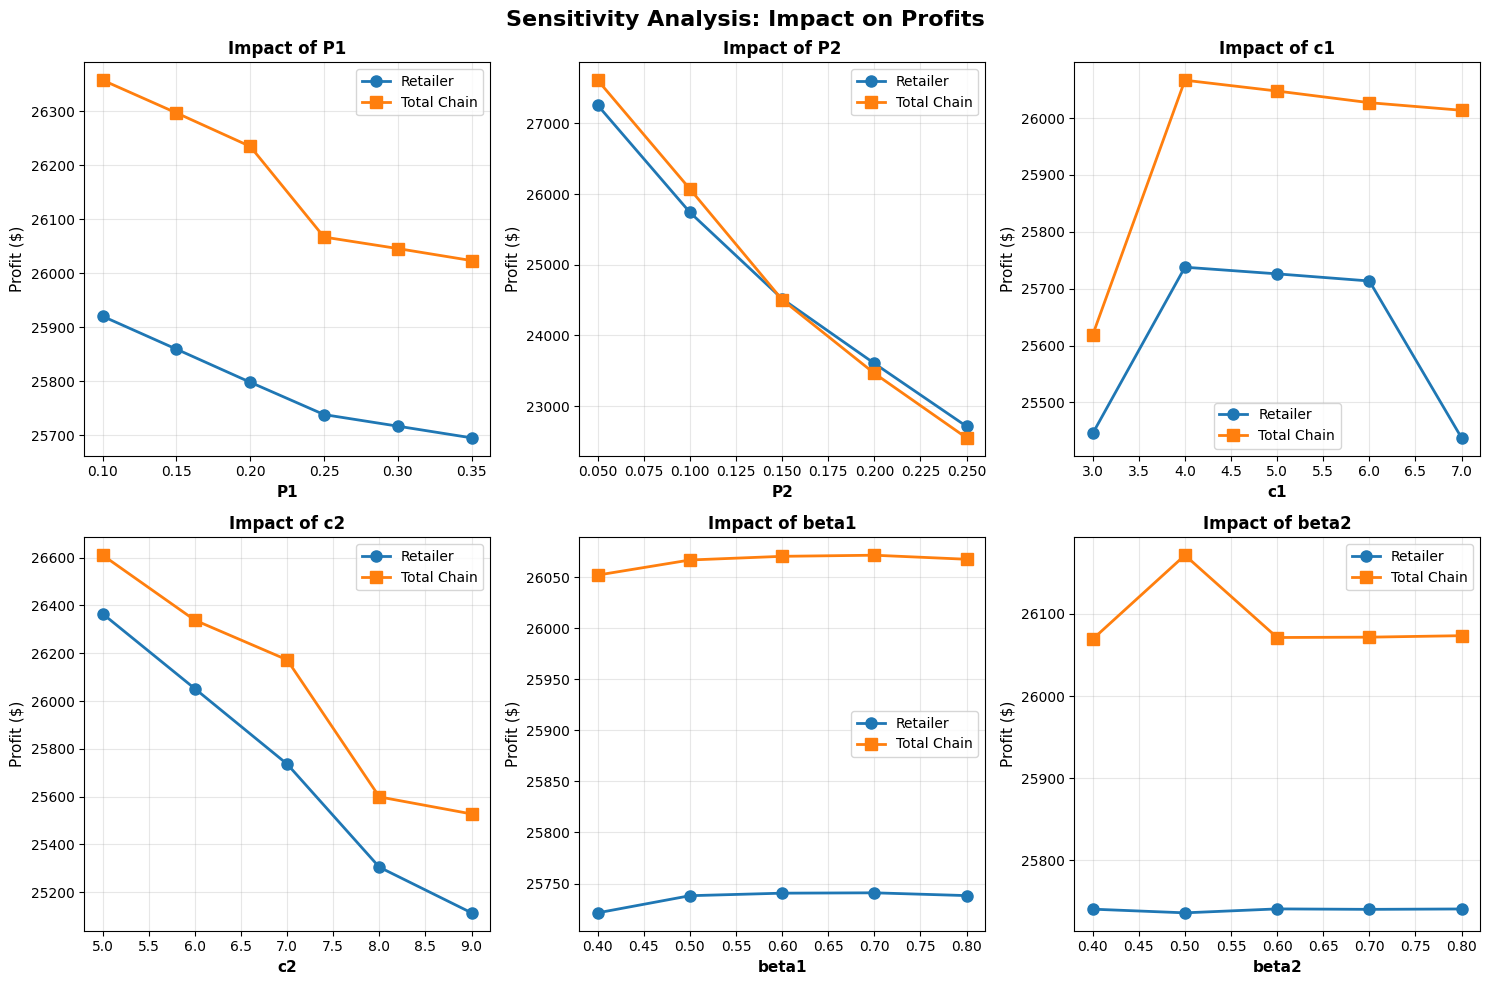


----------------------------------------------------------------------
 ALL ANALYSES COMPLETE
----------------------------------------------------------------------

Generated files:
  • convergence.png - Optimization convergence plot
  • sensitivity_analysis.png - Parameter sensitivity plots




In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import warnings
warnings.filterwarnings('ignore')

class ImprovedSupplyChainGA:
    def __init__(self, parameters):
        """Improved GA with better performance and validation"""
        self.params = parameters
        # Enhanced GA parameters
        self.population_size = 100  # Increased for better exploration
        self.generations = 200  # More generations
        self.mutation_rate = 0.2
        self.crossover_rate = 0.85
        self.elite_ratio = 0.15  # Keep top 15%

    def get_x_bar(self):
        """Mean of uniform distribution"""
        return (self.params['v'] + self.params['u']) / 2

    def demand_function(self, p):
        return self.params['a'] - self.params['b'] * (p - self.params['pr'])

    def f_x(self, x):
        """PDF of uniform distribution"""
        u, v = self.params['u'], self.params['v']
        return 1.0 / (v - u) if u <= x <= v else 0.0

    def calculate_primary_supplier_profit(self, genes):
        
        Qp, Qb, Ql, p, wl, wp, wb, eta = genes
        P1 = self.params['P1']
        c1 = self.params['c1']
        beta1 = self.params['beta1']
        wsp = self.params['wsp']
        x_bar = self.get_x_bar()
        lambda_ps = self.params['lambda_ps']

        profit = ((1 - P1) * wp * x_bar * Qp + 
                  P1 * wsp * x_bar * Qp - 
                  c1 * Qp + 
                  P1 * beta1 * (wp - wsp) * x_bar * Qp - 
                  wp * lambda_ps * (1 + P1) * Qp)
        return max(profit, -1e6)

    def calculate_backup_supplier_profit(self, genes):
       
        Qp, Qb, Ql, p, wl, wp, wb, eta = genes
        P1, P2 = self.params['P1'], self.params['P2']
        c2 = self.params['c2']
        beta2 = self.params['beta2']
        wsb = self.params['wsb']
        lambda_bs = self.params['lambda_bs']
        r = self.params['r']
        x_bar = self.get_x_bar()
        D_p = self.demand_function(p)
        u, v = self.params['u'], self.params['v']

        rev1 = P1 * ((1 - P2) * wb + P2 * wsb) * min(D_p, Qb)
        demand_remaining = max(0, D_p - x_bar * Qp)
        rev2 = (1 - P1) * ((1 - P2) * wb + P2 * wsb) * min(demand_remaining, Qb)

        cost1 = c2 * P1 * min(D_p, Qb)
        cost2 = c2 * (1 - P1) * min(demand_remaining, Qb)

        risk_cost = lambda_bs * wb * (1 + P2) * Qb
        return_benefit = (1 - P2) * r * Qb
        disruption = self.calculate_backup_disruption_integral(Qp, Qb, D_p, P1, P2, beta2, wb, wsb, u, v)

        profit = rev1 + rev2 - cost1 - cost2 - risk_cost + return_benefit + disruption
        return max(profit, -1e6)
    
    def calculate_backup_disruption_integral(self, Qp, Qb, D_p, P1, P2, beta2, wb, wsb, u, v):
        """Calculate: P₂β₂(wb - wsb)·E[(1-P₁)min{D(p) - xQp, Qb} + P₁min{D(p), Qb}]"""
        if Qp <= 0:
            return 0
        
        def integrand(x):
            term1 = (1 - P1) * min(max(0, D_p - x * Qp), Qb)
            term2 = P1 * min(D_p, Qb)
            return P2 * beta2 * (wb - wsb) * (term1 + term2) * self.f_x(x)
        
        try:
            result, _ = quad(integrand, u, v)
            return result
        except:
            return 0

    def calculate_local_supplier_profit(self, genes):
       
        Qp, Qb, Ql, p, wl, wp, wb, eta = genes
        return max((wl - self.params['c3']) * Ql, -1e6)

    def calculate_retailer_profit(self, genes):
       
        Qp, Qb, Ql, p, wl, wp, wb, eta = genes
        D_p = self.demand_function(p)

        # Feasibility checks
        if Qp >= D_p or D_p <= 0:
            return -1e6
        if not (D_p >= Qb and D_p >= Ql):
            return -1e6
        if not (self.params['c1'] < wp < wb < wl and self.params['c2'] < wb < p):
            return -1e6
        if not (0 < eta < 1):
            return -1e6
        if any(gene <= 0 for gene in genes):
            return -1e6

        P1, P2 = self.params['P1'], self.params['P2']
        cs, cd, cl, cu = self.params['cs'], self.params['cd'], self.params['cl'], self.params['cu']
        c3, r = self.params['c3'], self.params['r']
        lambda_ = self.params.get('lambda_', 0.05)
        pr = self.params['pr']
        u, v = self.params['u'], self.params['v']
        x_bar = self.get_x_bar()

        profit = 0

        # Scenario 1: P1·P2
        term1 = (p * min(Ql, D_p) - cs * max(0, D_p - Ql) - 
                 cd * max(0, Ql - D_p) - (wl + cl) * Ql)
        profit += P1 * P2 * term1

        # Scenario 2: P1·(1-P2)
        term2 = ((p - wb - cu) * Qb + p * min(Ql, max(0, D_p - Qb)) - 
                 (wl + cl) * Ql - cs * max(0, D_p - Qb - Ql) - 
                 cd * max(0, Ql + Qb - D_p) - r * Qb)
        profit += P1 * (1 - P2) * term2

        # Scenario 3: (1-P1)·P2
        base_term3 = (p - wp - cu) * min(x_bar * Qp, D_p)
        insurance_integral = self.calculate_insurance_integral_s3(Qp, Ql, D_p, eta, p, wl, cl, c3, u, v)
        int1 = self.calculate_integral_1(Qp, Ql, D_p, u, v)
        int2 = self.calculate_integral_2(Qp, Ql, D_p, u, v)
        int3 = self.calculate_integral_3(Qp, Ql, D_p, u, v)
        term3 = base_term3 + insurance_integral - cd * int1 - cs * int2 - cd * int3
        profit += (1 - P1) * P2 * term3

        # Scenario 4: (1-P1)·(1-P2)
        base_term4 = ((p - wp - cu) * min(x_bar * Qp, D_p) + 
                      (p - wb - cu) * min(Qb, max(0, D_p - x_bar * Qp)))
        insurance_integral_s4 = self.calculate_insurance_integral_s4(Qp, Qb, Ql, D_p, eta, p, wl, cl, c3, u, v)
        int1_s4 = self.calculate_integral_1(Qp, Ql, D_p, u, v)
        int4 = self.calculate_integral_4(Qp, Ql, Qb, D_p, u, v)
        int5 = self.calculate_integral_5(Qp, Ql, Qb, D_p, u, v)
        term4 = base_term4 + insurance_integral_s4 - cd * int1_s4 - r * Qb - cs * int4 - cd * int5
        profit += (1 - P1) * (1 - P2) * term4

        profit -= lambda_ * pr * Qp * (1 + eta) ** 2

        return profit

    def calculate_insurance_integral_s3(self, Qp, Ql, D_p, eta, p, wl, cl, c3, u, v):
        if Qp <= 0:
            return 0
        result = 0
        
        if eta > u:
            def integrand_bonus(x):
                remaining_demand = max(0, D_p - x * Qp)
                local_revenue = p * min(Ql, remaining_demand) - (wl + cl) * Ql
                return (eta - x) * local_revenue * self.f_x(x)
            try:
                lower, upper = max(u, 0), min(eta, v)
                if upper > lower:
                    bonus, _ = quad(integrand_bonus, lower, upper)
                    result += bonus
            except:
                pass
        
        if eta < v:
            def integrand_penalty(x):
                remaining_demand = max(0, D_p - x * Qp)
                local_revenue = p * min(Ql, remaining_demand) - (c3 + cl) * Ql
                return (x - eta) * local_revenue * self.f_x(x)
            try:
                lower, upper = max(eta, u), min(v, 1e6)
                if upper > lower:
                    penalty, _ = quad(integrand_penalty, lower, upper)
                    result += penalty
            except:
                pass
        return result

    def calculate_insurance_integral_s4(self, Qp, Qb, Ql, D_p, eta, p, wl, cl, c3, u, v):
        if Qp <= 0:
            return 0
        result = 0
        
        if eta > u:
            def integrand_bonus(x):
                remaining_after_primary = max(0, D_p - x * Qp)
                remaining_after_backup = max(0, remaining_after_primary - Qb)
                local_revenue = p * min(Ql, remaining_after_backup) - (wl + cl) * Ql
                return (eta - x) * local_revenue * self.f_x(x)
            try:
                lower, upper = max(u, 0), min(eta, v)
                if upper > lower:
                    bonus, _ = quad(integrand_bonus, lower, upper)
                    result += bonus
            except:
                pass
        
        if eta < v:
            def integrand_penalty(x):
                remaining_after_primary = max(0, D_p - x * Qp)
                remaining_after_backup = max(0, remaining_after_primary - Qb)
                local_revenue = p * min(Ql, remaining_after_backup) - (c3 + cl) * Ql
                return (x - eta) * local_revenue * self.f_x(x)
            try:
                lower, upper = max(eta, u), min(v, 1e6)
                if upper > lower:
                    penalty, _ = quad(integrand_penalty, lower, upper)
                    result += penalty
            except:
                pass
        return result

    def calculate_integral_1(self, Qp, Ql, D_p, u, v):
        if Qp <= 0:
            return 0
        lower, upper = max(D_p / Qp, u), v
        if lower >= upper:
            return 0
        try:
            integrand = lambda x: (x * Qp - D_p) * self.f_x(x)
            result, _ = quad(integrand, lower, upper)
            return max(0, result)
        except:
            return 0

    def calculate_integral_2(self, Qp, Ql, D_p, u, v):
        if Qp <= 0:
            return 0
        lower, upper = u, min((D_p - Ql) / Qp, v)
        if lower >= upper:
            return 0
        try:
            integrand = lambda x: (D_p - x * Qp - Ql) * self.f_x(x)
            result, _ = quad(integrand, lower, upper)
            return max(0, result)
        except:
            return 0

    def calculate_integral_3(self, Qp, Ql, D_p, u, v):
        if Qp <= 0:
            return 0
        lower = max((D_p - Ql) / Qp, u)
        upper = min(D_p / Qp, v)
        if lower >= upper:
            return 0
        try:
            integrand = lambda x: (x * Qp + Ql - D_p) * self.f_x(x)
            result, _ = quad(integrand, lower, upper)
            return max(0, result)
        except:
            return 0

    def calculate_integral_4(self, Qp, Ql, Qb, D_p, u, v):
        if Qp <= 0:
            return 0
        lower, upper = u, min((D_p - Qb - Ql) / Qp, v)
        if lower >= upper:
            return 0
        try:
            integrand = lambda x: (D_p - x * Qp - Qb - Ql) * self.f_x(x)
            result, _ = quad(integrand, lower, upper)
            return max(0, result)
        except:
            return 0

    def calculate_integral_5(self, Qp, Ql, Qb, D_p, u, v):
        if Qp <= 0:
            return 0
        lower = max((D_p - Qb - Ql) / Qp, u)
        upper = min((D_p - Ql) / Qp, v)
        if lower >= upper:
            return 0
        try:
            integrand = lambda x: (x * Qp + Qb + Ql - D_p) * self.f_x(x)
            result, _ = quad(integrand, lower, upper)
            return max(0, result)
        except:
            return 0

    def calculate_total_supply_chain_profit(self, genes):
        return (self.calculate_retailer_profit(genes) +
                self.calculate_primary_supplier_profit(genes) +
                self.calculate_backup_supplier_profit(genes) +
                self.calculate_local_supplier_profit(genes))

    def create_individual(self):
        """Improved initialization with better ranges"""
        p = np.random.uniform(self.params['pr']*1.2, self.params['pr']*2.0)
        D_p = self.demand_function(p)
        
        # Better quantity initialization
        Qp = np.random.uniform(10, min(D_p*0.7, 100))
        Qb = np.random.uniform(10, min(D_p*0.8, 80))
        Ql = np.random.uniform(10, min(D_p*0.8, 80))
        
        # Ensure profitable wholesale prices
        wp = np.random.uniform(self.params['c1']*1.5, self.params['c1']*3)
        wb = np.random.uniform(max(wp+2, self.params['c2']*1.5), wp*1.8)
        wl = np.random.uniform(wb+2, min(wb*1.5, p-10))
        
        eta = np.random.uniform(0.3, 0.7)
        return np.array([Qp, Qb, Ql, p, wl, wp, wb, eta])

    def repair_individual(self, ind):
        """Enhanced repair with better constraints"""
        ind = np.abs(ind)
        Qp, Qb, Ql, p, wl, wp, wb, eta = ind
        
        # Price constraints
        p = max(self.params['pr']*1.1, p)
        wp = np.clip(wp, self.params['c1']*1.2, p-15)
        wb = np.clip(wb, max(wp+1, self.params['c2']*1.2), p-10)
        wl = np.clip(wl, wb+1, p-5)
        
        D_p = self.demand_function(p)
        if D_p <= 0:
            p = self.params['pr']*1.5
            D_p = self.demand_function(p)
        
        # Quantity constraints
        Qp = min(max(Qp, 5), D_p*0.8)
        Qb = min(max(Qb, 5), D_p*0.95)
        Ql = min(max(Ql, 5), D_p*0.95)
        eta = np.clip(eta, 0.1, 0.9)
        
        return np.array([Qp, Qb, Ql, p, wl, wp, wb, eta])

    def tournament_selection(self, pop, fitness, t_size=4):
        selected = []
        for _ in range(len(pop)):
            idx = np.random.choice(len(pop), t_size, replace=False)
            winner_idx = idx[np.argmax(fitness[idx])]
            selected.append(pop[winner_idx].copy())
        return np.array(selected)

    def crossover(self, p1, p2):
        if np.random.random() < self.crossover_rate:
            # Blend crossover for better exploration
            alpha = np.random.random(len(p1))
            c1 = alpha * p1 + (1 - alpha) * p2
            c2 = alpha * p2 + (1 - alpha) * p1
            return c1, c2
        return p1.copy(), p2.copy()

    def mutate(self, ind):
        """Adaptive mutation"""
        if np.random.random() < self.mutation_rate:
            ind = ind.copy()
            mutation_mask = np.random.random(len(ind)) < 0.4
            for i in range(len(ind)):
                if mutation_mask[i]:
                    if i == 7:  # eta
                        ind[i] += np.random.normal(0, 0.1)
                    elif i == 3:  # price
                        ind[i] += np.random.normal(0, np.abs(ind[i]) * 0.08)
                    else:
                        ind[i] += np.random.normal(0, np.abs(ind[i]) * 0.15)
        return self.repair_individual(ind)

    def optimize(self, verbose=True):
        """Enhanced optimization with convergence tracking"""
        if verbose:
            print(" Enhanced GA with Performance Improvements")
            print(f"Population: {self.population_size}, Generations: {self.generations}")
            print(f"Using x̄ = {self.get_x_bar():.3f}\n")

        population = np.array([self.create_individual() for _ in range(self.population_size)])
        best_fitness_history = []
        best_individual = None
        best_fitness = -np.inf
        stagnation_counter = 0

        for gen in range(self.generations):
            fitness = np.array([self.calculate_retailer_profit(ind) for ind in population])
            
            idx_best = np.argmax(fitness)
            if fitness[idx_best] > best_fitness:
                improvement = fitness[idx_best] - best_fitness
                best_fitness = fitness[idx_best]
                best_individual = population[idx_best].copy()
                stagnation_counter = 0
                if verbose and gen % 10 == 0:
                    print(f"Gen {gen}: Best = {best_fitness:.2f} (↑{improvement:.2f})")
            else:
                stagnation_counter += 1
            
            best_fitness_history.append(best_fitness)

            if gen < self.generations - 1:
                # Enhanced selection with elitism
                selected = self.tournament_selection(population, fitness)
                new_pop = []
                
                elite_count = max(1, int(self.population_size * self.elite_ratio))
                elite_idx = np.argsort(fitness)[-elite_count:]
                for idx in elite_idx:
                    new_pop.append(population[idx])
                
                # Adaptive mutation rate based on stagnation
                if stagnation_counter > 20:
                    self.mutation_rate = min(0.4, self.mutation_rate * 1.1)
                else:
                    self.mutation_rate = max(0.15, self.mutation_rate * 0.98)
                
                while len(new_pop) < self.population_size:
                    p1, p2 = selected[np.random.choice(len(selected), 2, replace=False)]
                    c1, c2 = self.crossover(p1, p2)
                    c1 = self.mutate(c1)
                    c2 = self.mutate(c2)
                    new_pop.extend([c1, c2])
                
                population = np.array(new_pop[:self.population_size])

        if best_individual is not None:
            profit_breakdown = {
                'retailer': best_fitness,
                'primary': self.calculate_primary_supplier_profit(best_individual),
                'backup': self.calculate_backup_supplier_profit(best_individual),
                'local': self.calculate_local_supplier_profit(best_individual),
                'total_chain': self.calculate_total_supply_chain_profit(best_individual)
            }
        else:
            profit_breakdown = {'retailer': -np.inf, 'primary': -np.inf, 
                               'backup': -np.inf, 'local': -np.inf, 'total_chain': -np.inf}

        return {
            'best_solution': best_individual,
            'best_profit': best_fitness,
            'fitness_history': best_fitness_history,
            'method': 'Enhanced GA',
            'profit_breakdown': profit_breakdown
        }

    def print_solution(self, result):
        if result['best_solution'] is None:
            print(" No feasible solution found!")
            return

        sol = result['best_solution']
        profit = result['best_profit']
        breakdown = result.get('profit_breakdown', {})

        print(f"\n{'='*70}\nOPTIMIZED SOLUTION\n{'='*70}")
        print(f" Retailer Profit: ${profit:,.2f}")
        print(f"\nDecision Variables:")
        print(f"   Quantities: Qp={sol[0]:.2f}, Qb={sol[1]:.2f}, Ql={sol[2]:.2f}")
        print(f"   Price: p=${sol[3]:.2f}")
        print(f"   Wholesale: wp=${sol[5]:.2f}, wb=${sol[6]:.2f}, wl=${sol[4]:.2f}")
        print(f"   Insurance: η={sol[7]:.3f}")
        print(f"\nPROFIT BREAKDOWN:")
        print(f"   Retailer:   ${breakdown.get('retailer', 0):>12,.2f}")
        print(f"   Primary:    ${breakdown.get('primary', 0):>12,.2f}")
        print(f"   Backup:     ${breakdown.get('backup', 0):>12,.2f}")
        print(f"   Local:      ${breakdown.get('local', 0):>12,.2f}")
        print(f"   {'─'*40}")
        print(f"   Total Chain:${breakdown.get('total_chain', 0):>12,.2f}")
        
        # Validation metrics
        D_p = self.demand_function(sol[3])
        print(f"\n Validation:")
        print(f"   Demand D(p) = {D_p:.2f}")
        print(f"   Supply utilization: Qp/D={sol[0]/D_p*100:.1f}%, Qb/D={sol[1]/D_p*100:.1f}%")
        print(f"   Price margins: (p-wl)={sol[3]-sol[4]:.2f}, (wl-wb)={sol[4]-sol[6]:.2f}")


def run_multiple_trials(n_trials=5, params=None):
    """Run multiple GA trials to assess consistency and find best solution"""
    if params is None:
        params = {
            'a': 500, 'b': 20, 'pr': 100,
            'u': 0.4, 'v': 0.9,
            'P1': 0.25, 'P2': 0.1,
            'wsp': 3, 'beta1': 0.6, 'c1': 4, 'lambda_ps': 0.05,
            'wsb': 8, 'c2': 7, 'beta2': 0.6, 'lambda_bs': 0.05,
            'r': 1, 'wl0': 40, 'c3': 20, 'cs': 10, 'cd': 5,
            'cl': 40, 'cu': 3, 'lambda_': 0.05, 'eta0': 0.6
        }
    
    print(f"\n{'='*70}")
    print(f" RUNNING {n_trials} INDEPENDENT GA TRIALS FOR VALIDATION")
    print(f"{'='*70}\n")
    
    results = []
    retailer_profits = []
    total_chain_profits = []
    
    for trial in range(n_trials):
        print(f"\n{'─'*70}")
        print(f"Trial {trial + 1}/{n_trials}")
        print(f"{'─'*70}")
        
        ga = ImprovedSupplyChainGA(params)
        result = ga.optimize(verbose=False)
        results.append(result)
        
        retailer_profits.append(result['best_profit'])
        total_chain_profits.append(result['profit_breakdown']['total_chain'])
        
        print(f"✓ Retailer Profit: ${result['best_profit']:,.2f}")
        print(f"✓ Total Chain: ${result['profit_breakdown']['total_chain']:,.2f}")
    
    # Find best solution
    best_idx = np.argmax(retailer_profits)
    best_result = results[best_idx]
    
    # Statistics
    print(f"\n{'-'*70}")
    print(f" STATISTICAL SUMMARY ACROSS {n_trials} TRIALS")
    print(f"{'-'*70}")
    print(f"\nRetailer Profit:")
    print(f"   Mean:    ${np.mean(retailer_profits):>12,.2f}")
    print(f"   Std Dev: ${np.std(retailer_profits):>12,.2f}")
    print(f"   Min:     ${np.min(retailer_profits):>12,.2f}")
    print(f"   Max:     ${np.max(retailer_profits):>12,.2f}")
    print(f"   Range:   ${np.max(retailer_profits) - np.min(retailer_profits):>12,.2f}")
    
    print(f"\nTotal Supply Chain Profit:")
    print(f"   Mean:    ${np.mean(total_chain_profits):>12,.2f}")
    print(f"   Std Dev: ${np.std(total_chain_profits):>12,.2f}")
    print(f"   Min:     ${np.min(total_chain_profits):>12,.2f}")
    print(f"   Max:     ${np.max(total_chain_profits):>12,.2f}")
    
    # Coefficient of variation (lower is better - more consistent)
    cv_retailer = (np.std(retailer_profits) / np.mean(retailer_profits)) * 100
    cv_chain = (np.std(total_chain_profits) / np.mean(total_chain_profits)) * 100
    
    print(f"\nConsistency Metrics (lower = more consistent):")
    print(f"   Retailer CV: {cv_retailer:.2f}%")
    print(f"   Chain CV:    {cv_chain:.2f}%")
    
    print(f"\n{'-'*70}")
    print(f" BEST SOLUTION (Trial {best_idx + 1})")
    print(f"{'-'*70}")
    
    ga = ImprovedSupplyChainGA(params)
    ga.print_solution(best_result)
    
    return best_result, results


def sensitivity_analysis(base_params=None):
    """Analyze sensitivity to key parameters"""
    if base_params is None:
        base_params = {
            'a': 500, 'b': 20, 'pr': 100,
            'u': 0.4, 'v': 0.9,
            'P1': 0.25, 'P2': 0.1,
            'wsp': 3, 'beta1': 0.6, 'c1': 4, 'lambda_ps': 0.05,
            'wsb': 8, 'c2': 7, 'beta2': 0.6, 'lambda_bs': 0.05,
            'r': 1, 'wl0': 40, 'c3': 20, 'cs': 10, 'cd': 5,
            'cl': 40, 'cu': 3, 'lambda_': 0.05, 'eta0': 0.6
        }
    
    print(f"\n{'-'*70}")
    print(" SENSITIVITY ANALYSIS")
    print(f"{'-'*70}\n")
    
    # Parameters to analyze
    sensitivity_params = {
        'P1': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35],
        'P2': [0.05, 0.1, 0.15, 0.2, 0.25],
        'c1': [3, 4, 5, 6, 7],
        'c2': [5, 6, 7, 8, 9],
        'beta1': [0.4, 0.5, 0.6, 0.7, 0.8],
        'beta2': [0.4, 0.5, 0.6, 0.7, 0.8],
    }
    
    results = {}
    
    for param_name, param_values in sensitivity_params.items():
        print(f"\n{'─'*70}")
        print(f"Analyzing: {param_name}")
        print(f"{'─'*70}")
        
        retailer_profits = []
        chain_profits = []
        
        for value in param_values:
            test_params = base_params.copy()
            test_params[param_name] = value
            
            ga = ImprovedSupplyChainGA(test_params)
            result = ga.optimize(verbose=False)
            
            retailer_profits.append(result['best_profit'])
            chain_profits.append(result['profit_breakdown']['total_chain'])
            
            print(f"  {param_name}={value:.3f}: Retailer=${result['best_profit']:,.2f}, Chain=${result['profit_breakdown']['total_chain']:,.2f}")
        
        results[param_name] = {
            'values': param_values,
            'retailer_profits': retailer_profits,
            'chain_profits': chain_profits
        }
    
    # Plot results
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Sensitivity Analysis: Impact on Profits', fontsize=16, fontweight='bold')
    
    for idx, (param_name, data) in enumerate(results.items()):
        row, col = idx // 3, idx % 3
        ax = axes[row, col]
        
        ax.plot(data['values'], data['retailer_profits'], 'o-', label='Retailer', linewidth=2, markersize=8)
        ax.plot(data['values'], data['chain_profits'], 's-', label='Total Chain', linewidth=2, markersize=8)
        
        ax.set_xlabel(param_name, fontsize=11, fontweight='bold')
        ax.set_ylabel('Profit ($)', fontsize=11)
        ax.set_title(f'Impact of {param_name}', fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.ticklabel_format(style='plain', axis='y')
    
    plt.tight_layout()
    plt.savefig('sensitivity_analysis.png', dpi=300, bbox_inches='tight')
    print(f"\n✓ Sensitivity analysis plot saved as 'sensitivity_analysis.png'")
    plt.show()
    
    return results


def plot_convergence(results, title="GA Convergence"):
    """Plot convergence history"""
    plt.figure(figsize=(10, 6))
    plt.plot(results['fitness_history'], linewidth=2, color='#2E86AB')
    plt.xlabel('Generation', fontsize=12, fontweight='bold')
    plt.ylabel('Best Fitness (Retailer Profit)', fontsize=12, fontweight='bold')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.ticklabel_format(style='plain', axis='y')
    plt.tight_layout()
    plt.savefig('convergence.png', dpi=300, bbox_inches='tight')
    print(f"\n✓ Convergence plot saved as 'convergence.png'")
    plt.show()

def plot_profit_breakdown(result):
    """
    Creates a bar chart showing profit of:
    Retailer, Primary Supplier, Backup Supplier, Local Supplier, Total Chain
    """
    breakdown = result["profit_breakdown"]

    labels = ['Retailer', 'Primary', 'Backup', 'Local', 'Total Chain']
    profits = [
        breakdown['retailer'],
        breakdown['primary'],
        breakdown['backup'],
        breakdown['local'],
        breakdown['total_chain']
    ]

    plt.figure(figsize=(8, 5))
    plt.bar(labels, profits)   # allowed default colors
    plt.xlabel("Supply Chain Agent", fontsize=12)
    plt.ylabel("Profit ($)", fontsize=12)
    plt.title("Profit Breakdown of Supply Chain Members", fontsize=14)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_decision_variables(result):
    """
    Plots the optimized decision variables as a bar chart:
    Qp, Qb, Ql, p, wp, wb, wl, η
    """
    sol = result["best_solution"]
    
    labels = ["Qp", "Qb", "Ql", "Price p", "wl", "wp", "wb", "eta"]
    values = [
        sol[0], sol[1], sol[2], sol[3],
        sol[4], sol[5], sol[6], sol[7]
    ]
    
    plt.figure(figsize=(10, 5))
    plt.bar(labels, values)
    plt.ylabel("Value", fontsize=12)
    plt.title("Optimized Decision Variables", fontsize=14)
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()




def main():
    """Main execution function"""
    print("\n" + "-"*70)
    print(" SUPPLY CHAIN OPTIMIZATION WITH GENETIC ALGORITHM")
    print("="*70)
    
    # Default parameters
    params = {
        'a': 500, 'b': 20, 'pr': 100,
        'u': 0.4, 'v': 0.9,
        'P1': 0.25, 'P2': 0.1,
        'wsp': 3, 'beta1': 0.6, 'c1': 4, 'lambda_ps': 0.05,
        'wsb': 8, 'c2': 7, 'beta2': 0.6, 'lambda_bs': 0.05,
        'r': 1, 'wl0': 40, 'c3': 20, 'cs': 10, 'cd': 5,
        'cl': 40, 'cu': 3, 'lambda_': 0.05, 'eta0': 0.6
    }
    
    # Option 1: Single run
    print("\n" + "-"*70)
    print("OPTION 1: Single Optimization Run")
    print("="*70)
    ga = ImprovedSupplyChainGA(params)
    result = ga.optimize(verbose=True)
    ga.print_solution(result)
    plot_convergence(result)
    plot_profit_breakdown(result)
    plot_decision_variables(result)

    
    # Option 2: Multiple trials for validation
    print("\n\n" + "-"*70)
    print("OPTION 2: Multiple Trials for Validation")
    print("-"*70)
    best_result, all_results = run_multiple_trials(n_trials=5, params=params)
    
    # Option 3: Sensitivity analysis
    print("\n\n" + "-"*70)
    print("OPTION 3: Sensitivity Analysis")
    print("-"*70)
    sensitivity_results = sensitivity_analysis(params)
    
    print("\n" + "-"*70)
    print(" ALL ANALYSES COMPLETE")
    print("-"*70)
    print("\nGenerated files:")
    print("  • convergence.png - Optimization convergence plot")
    print("  • sensitivity_analysis.png - Parameter sensitivity plots")
    print("\n")


if __name__ == "__main__":
    main()